### Score: 42

Q1.[16.5+20+5.5]

Bonus.[0]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

1.1

In [3]:
# 读取人为碳排放速率（gamma）数据
gamma_df = pd.read_excel('global_1751_2014.xlsx', sheet_name='Sheet1')
gamma_df = gamma_df.iloc[2:, [0, 1]]  # 提取年份和 Cement 列
gamma_df.columns = ['Year', 'Total']
gamma_df['Year'] = gamma_df['Year'].astype(int)
gamma_df['Total'] = gamma_df['Total'].astype(float)
gamma_df['Total'] = gamma_df['Total'] * 1e-3

# 筛选出 1987-2004 年的数据
gamma_df = gamma_df[(gamma_df['Year'] >= 1987) & (gamma_df['Year'] <= 2004)]


def get_gamma(t):
    years = gamma_df['Year'] - time_span[0]  # 调整年份以开始于0
    gamma_values = gamma_df['Total']  # 使用正确的列名 'Total'
    return np.interp(t, years, gamma_values)  # 插值以获取 gamma 值

In [4]:
# 提取初始条件
initial_year = 1986
N1_0 = 740  # PgC (1986年的大气CO2)
N2_0 = 900  # PgC (1986年的海洋CO2)

# 速率系数和参数设置
k12 = 105 / 740  # PgC/year
k21 = 102 / 900  # PgC/year
ppm_conversion = 2.13  # 1 ppm = 2.13 PgC

# 定义方程1和2（无缓冲效应）
def two_box_model_no_buffer(t, y):
    N1, N2 = y
    gamma = get_gamma(t)  # 获取 gamma 值
    dN1_dt = -k12 * N1 + k21 * N2 + gamma
    dN2_dt = k12 * N1 - k21 * N2
    return [dN1_dt, dN2_dt]

# 求解方程1和2（无缓冲效应）
time_span = [1987, 2004]
t_eval = np.arange(1987, 2005, 1) 
solution_no_buffer = solve_ivp(two_box_model_no_buffer, time_span, [N1_0, N2_0], t_eval=t_eval, method='RK45')

# 提取结果（无缓冲效应）
t_no_buffer = solution_no_buffer.t  # 时间
N1_no_buffer = solution_no_buffer.y[0]  # 大气碳浓度 (PgC)
N1_no_buffer_ppm = N1_no_buffer / ppm_conversion

1.2

In [39]:
P0 = 290.21  # 工业化前 CO2 浓度 (ppm)
C0 = 2.057e-3  # 工业化前无机碳浓度 (mol/L)
N2_eq = 821  # 平衡浓度 PgC

# 定义缓冲因子计算函数
def calculate_buffer_factor(CO2_ppm):
    xi = 3.69 + 1.86* 10**-2 * CO2_ppm - 1.80* 10**-6 * CO2_ppm**2
    return xi
    
# 定义方程3和4（带缓冲效应）
def two_box_model_with_buffer(t, y):
    N1, N2 = y
    gamma_val = get_gamma(t)  # 获取 gamma 值
    xi = calculate_buffer_factor(N1/2.13)  # 计算缓冲因子
    dN1_dt = -k12 * N1 + k21 * (N2_eq + xi * (N2 - N2_eq)) + gamma_val
    dN2_dt = k12 * N1 - k21 * (N2_eq + xi * (N2 - N2_eq))
    return [dN1_dt, dN2_dt]

# 求解方程3和4（带缓冲效应）
solution_with_buffer = solve_ivp(two_box_model_with_buffer, [1987, 2004], [N1_0, N2_0], t_eval = np.arange(1987, 2005, 1) , method='RK45')

# 提取结果（带缓冲效应）
t_with_buffer = solution_with_buffer.t  # 时间
N1_with_buffer = solution_with_buffer.y[0]  # 大气碳浓度 (PgC)
N1_with_buffer_ppm = N1_with_buffer / ppm_conversion

1.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


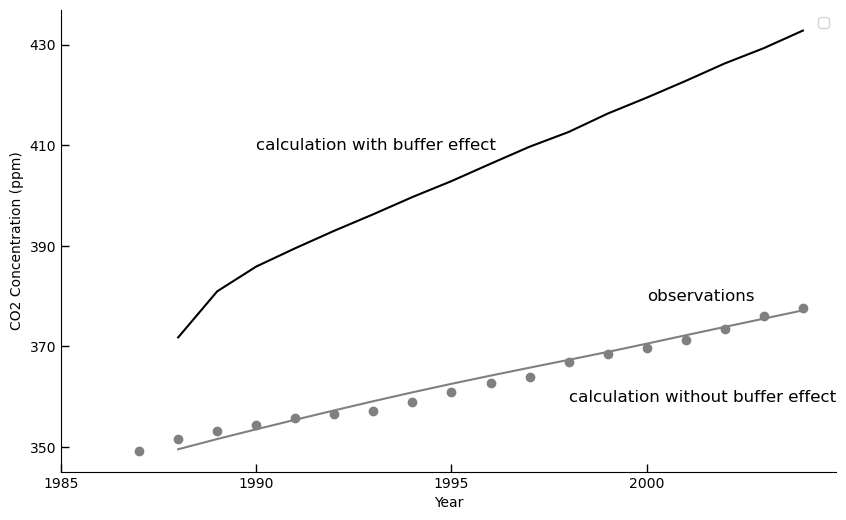

In [42]:
# 读取观测 CO2 数据
observed_df = pd.read_csv('co2_annmean_mlo.csv', comment='#')
observed_df = observed_df[(observed_df['year'] >= 1987) & (observed_df['year'] <= 2004)]
observed_years = observed_df['year'].values
observed_co2 = observed_df['mean'].values


# 绘图显示无缓冲效应和带缓冲效应的结果
plt.figure(figsize=(10, 6))
plt.plot(t_no_buffer[1:], N1_no_buffer_ppm[1:], color='gray')
plt.plot(t_with_buffer[1:], N1_with_buffer_ppm[1:],  color='black')
plt.scatter(observed_years, observed_co2, color='gray', zorder=5)
# 添加线旁边的标签
plt.text(1990, 410, 'calculation with buffer effect', fontsize=12, color='black', ha='left', va='center') 
plt.text(1998, 360, 'calculation without buffer effect', fontsize=12, color='black', ha='left', va='center') 
plt.text(2000, 380, 'observations', fontsize=12, color='black', ha='left', va='center') 

plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')

# 设置横坐标
years = np.arange(1985, 2005, 5)  # 从1988到2004，步长为5
plt.xticks(years)

# 设置纵坐标：
y_labels = np.arange(350, 440, 20)  # 每20显示一个标签
plt.yticks(y_labels)

# 设置刻度线向内
plt.tick_params(axis='both', direction='in', length=6, width=1)  # 坐标轴的刻度线向内
# 调整边框，去掉上框和右框
plt.gca().spines['top'].set_visible(False)  # 去掉上框
plt.gca().spines['right'].set_visible(False)  # 去掉右框

# 移除网格线
plt.grid(False)

# 显示图例
plt.legend()

# 显示图表
plt.show()